Scraping newspaper articles from derstandard.at
===

* relating to
    * Croatia
    * Serbia
    * Hungary (control I)
    * Slowakia (control II)
* direct search (no intermediate search step via twitter)

I focus on articles from derstandard, because it's among the most popular online newspapers in Austria and because building a scraper for a specific newspaper and scraping itself is a tedious and time-consuming task. This should serve as a proof-of-concept and can later be adapted to include a larger set of Austrian newspapers.

In [1]:
import jupyter_black

jupyter_black.load()

## Imports and functions

In [2]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.options import Options
from time import sleep
import squarify


data_dir = "data/derstandard"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def get_derstandard_article(url):
    """

    Scrapes article from derstandard.at
    and returns title, subtitle and
    complete article text

    """
    try:
        options = Options()
        options.add_argument("-headless")
        driver = webdriver.Firefox(options=options)
        driver.set_script_timeout(30)
        driver.get(url)

        # switch to iframe (when it is avilable) with button and click it
        iframes = driver.find_elements(By.TAG_NAME, "iframe")

        # wait for both iframes to appear
        while len(iframes) < 2:
            iframes = driver.find_elements(By.TAG_NAME, "iframe")

        iframe = iframes[1]
        WebDriverWait(driver, 20).until(
            EC.frame_to_be_available_and_switch_to_it(iframe)
        )
        WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
        ).click()

        # switch to new window
        new_window = driver.window_handles
        driver.switch_to.window(new_window[0])

        sleep(2)

        if url[:45] == "https://www.derstandard.at/jetzt/livebericht/":
            article_title = driver.find_element(By.ID, "content-header").text
            article_subtitle = ""
            article_text = driver.find_element(By.ID, "content-main").text
            article_date = driver.find_element(By.CLASS_NAME, "date").text

        else:
            article_title = driver.find_element(By.CLASS_NAME, "article-title").text
            article_subtitle = driver.find_element(
                By.CLASS_NAME, "article-subtitle"
            ).text
            article_body = driver.find_element(By.CLASS_NAME, "article-body")
            article_text = article_body.text
            article_date = driver.find_element(By.TAG_NAME, "time").text

        # translate German to English dates
        d = {
            "Jänner": "Jan",
            "Januar": "Jan",
            "Feber": "Feb",
            "Februar": "Feb",
            "März": "Mar",
            "Mai": "May",
            "Juni": "Jun",
            "Juli": "Jul",
            "Oktober": "Oct",
            "Dezember": "Dec",
        }

        article_date = " ".join(d.get(ele, ele) for ele in article_date.split())
        article_date = pd.Timestamp(article_date).isoformat()

    except Exception as e:
        driver.quit()
        print("Could not process url:", url, e)
        return None

    driver.quit()

    return article_title, article_subtitle, article_text, article_date

## Search

### Search words for countries

In [3]:
countries_min = dict(
    serbia="serbien",
    croatia="kroatien",
    slovakia="slowakei",
    hungary="ungarn",
    albania="albanien",
    austria="österreich",
    bosnia="bosnien",
    montenegro="montenegro",
    spain="spanien",
    slovenia="slowenien",
    kosovo="kosovo",
    northmacedonia="mazedonien",
    bulgaria="bulgarien",
    romania="rumänien",
    yugoslavia="jugoslawien",
)

### Define countries of interest

Articles that include Serbia or Yugoslavia (until 2003), but do not include Croatia will be later treated as "Serbia", Articles that include Croatia, but not Serbia or Yugoslavia (until 2003) will be later treated as "Croatia". The reason for this is that "Yugoslavia" was the name for the country later called Serbia (Serbia & Montenegro). To make this visible, I will re-label Yugoslavia-articles between 1998 and 2003 from "jugoslawien" to "serbien".  It's difficult to know whether an article referes to old Yugoslavia before the war or to the country later called Serbia (& Montenegro), but I assume that between 1998 and 2003 the articles refere to the latter. I could be wrong, of course, but excluding these articles could make things worse.

In [4]:
cois = [
    "serbia",
    "yugoslavia",
    "croatia",
    "slovenia",
    "northmacedonia",
    "bosnia",
    "montenegro",
    "kosovo",
    "slovakia",
    "hungary",
    "albania",
]

### Retrieve urls of relevant articles and store them in textfiles

The news archive dates back to 1997, the articles found on the subject are from 1998&ndash;2023. The breakup of Yugoslavia started in 1991, followed by the war in Croatia in the same year and the war in Bosnia in 1992. Armed conflict ended in 1995. In 1998, when the first newspaper articles are available, the war in Kosovo started and lasted until 1999, when NATO started bombing Serbia (back then "Yugoslavia") between March and June.

In [ ]:
if os.path.exists(data_dir+"/urls") == False:
    os.makedirs(data_dir+"/urls")

    
# iterate over countries
for coi in cois:

    country = countries_min[coi]

    # iterate over years
    for year in range(1997, 2023 + 1):

        page = 0

        # iterate over pages
        while True:

            page += 1

            url = f"https://www.derstandard.at/search?n=&fd={year}-01-01&td={year}-12-31&s=date&query={country}&p={page}"

            options = Options()
            options.add_argument("-headless")
            driver = webdriver.Firefox(options=options)
            driver.set_script_timeout(30)

            driver.get(url)

            # switch to iframe (when it is avilable) with button and click it
            iframes = driver.find_elements(By.TAG_NAME, "iframe")

            # wait for both iframes to appear
            while len(iframes) < 2:
                iframes = driver.find_elements(By.TAG_NAME, "iframe")

            iframe = iframes[1]

            WebDriverWait(driver, 20).until(
                EC.frame_to_be_available_and_switch_to_it(iframe)
            )

            WebDriverWait(driver, 20).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
            ).click()

            # switch to new window
            driver.get(url)

            sleep(2)

            article_elements = driver.find_elements(By.CLASS_NAME, "teaser-inner")

            if len(article_elements) == 0:
                driver.quit()
                break

            urls = [
                article.find_element(By.TAG_NAME, "a").get_attribute("href")
                for article in article_elements
            ]

            with open(data_dir + f"/urls/{country}_{year}_{page}.txt", "w") as fp:
                fp.writelines("\n".join(urls))

            driver.quit()

### Create dataframe from textfiles

In [5]:
import glob


txt_files = glob.glob(data_dir + "/urls/*.txt")
l = []

for f in txt_files:
    df_tmp = pd.read_csv(f, names=["url"])
    x = f.replace(data_dir + "/urls", "")[1:-4]
    df_tmp[["country", "year", "page"]] = x.split("_")
    df_tmp["id"] = df_tmp["url"].apply(
        lambda x: x.split("/")[5] if x.split("/")[3] == "jetzt" else x.split("/")[4]
    )
    l.append(df_tmp)

df = pd.concat(l, axis=0, ignore_index=True)
df = df.drop("page", axis=1)

# year from string to int
df["year"] = df["year"].astype(int)

# Re-label Yugoslavia articles between 1998 and 2003 to Serbia
df.loc[
    (df.country == countries_min["yugoslavia"]) & (df.year <= 2003) & (df.year > 1995),
    "country",
] = countries_min["serbia"]

# Drop duplicates (some articles appeared on more than one search result page)
df = df.drop_duplicates(keep="first").reset_index(drop=True)

# show the number of found articles
df.groupby("country").count()[["url"]].rename(columns=dict(url="count")).sort_values(
    "count", ascending=False
)

,count
country,
ungarn,26957
serbien,16520
kroatien,15802
slowakei,14204
slowenien,13888
kosovo,11730
bosnien,9466
mazedonien,5027
montenegro,4703


### Frequency of articles with country keywords


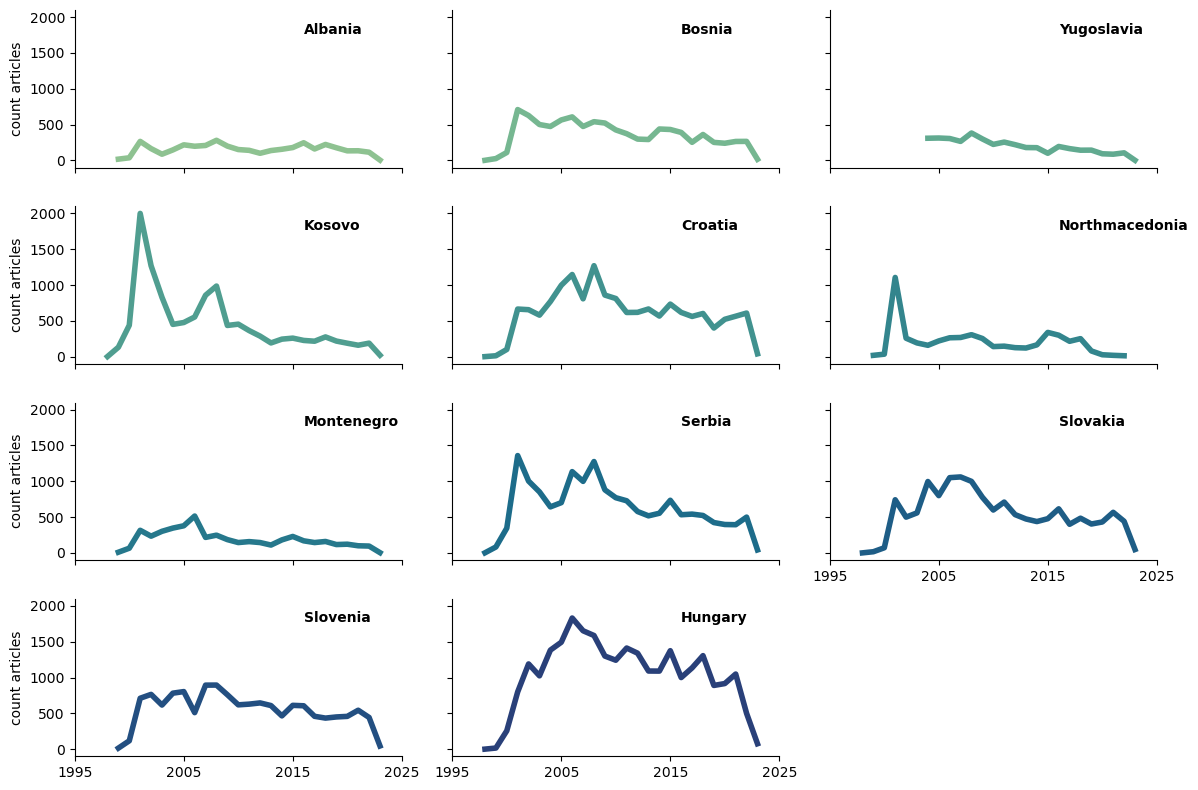

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plt = df.groupby(["country", "year"]).count()[["url"]].reset_index()
df_plt.year = df_plt.year.astype(int)

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_plt,
    x="year",
    y="url",
    col="country",
    hue="country",
    kind="line",
    palette="crest",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=2,
    legend=False,
)

# create a reverse dictionary
countries_min_rev = {val: key for (key, val) in countries_min.items()}

# Iterate over each subplot to customize further
for country, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(
        0.7,
        0.85,
        countries_min_rev[country].capitalize(),
        transform=ax.transAxes,
        fontweight="bold",
    )


# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "count articles")
g.tight_layout()

### Create grouped dataframes

In [7]:
df_grp = (
    df.sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)

df_grp_no_controls = (
    df.loc[~df["country"].isin(["slowakei", "albanien", "ungarn"])]
    .sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)


df_grp["country"] = df_grp["country"].apply(lambda x: "_".join(x))
df_grp_no_controls["country"] = df_grp_no_controls["country"].apply(
    lambda x: "_".join(x)
)

country_count = (
    df_grp.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)
country_count_no_controls = (
    df_grp_no_controls.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)

### Plot treemaps to visualize the proportions of published articles per keyword

In [8]:
def plot_count(cois, country_count, countries_min, threshold=100, alt_title=None):
    """
    Plot for number of articles for a given country.

    - set cois to empty list for all countries

    """

    filter_list = [countries_min[coi] for coi in cois]

    if cois != []:
        country_count = country_count.loc[
            country_count.country.str.contains("|".join(filter_list))
        ].reset_index(drop=True)
        title_country = ", ".join([coi.capitalize() for coi in cois])
    else:
        title_country = "all countries"

    other_sum = country_count.loc[country_count["count"] < threshold, "count"].sum()
    data = (
        country_count.loc[country_count["count"] >= threshold]
        .copy()
        .reset_index(drop=True)
    )

    data.loc[len(data)] = ["other", other_sum]
    data["country"] = data["country"].str.replace("_", "+\n")

    plt.figure(figsize=(12, 9))
    squarify.plot(
        sizes=data["count"],
        label=data["country"],
        alpha=0.7,
        text_kwargs=dict(fontsize=7),
    )

    plt.axis("off")
    if alt_title == None:
        plt.title(
            f"Articles about {title_country} 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )
    else:
        plt.title(
            alt_title
            + f" 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )

#### All scraped articles (incl. control countries)

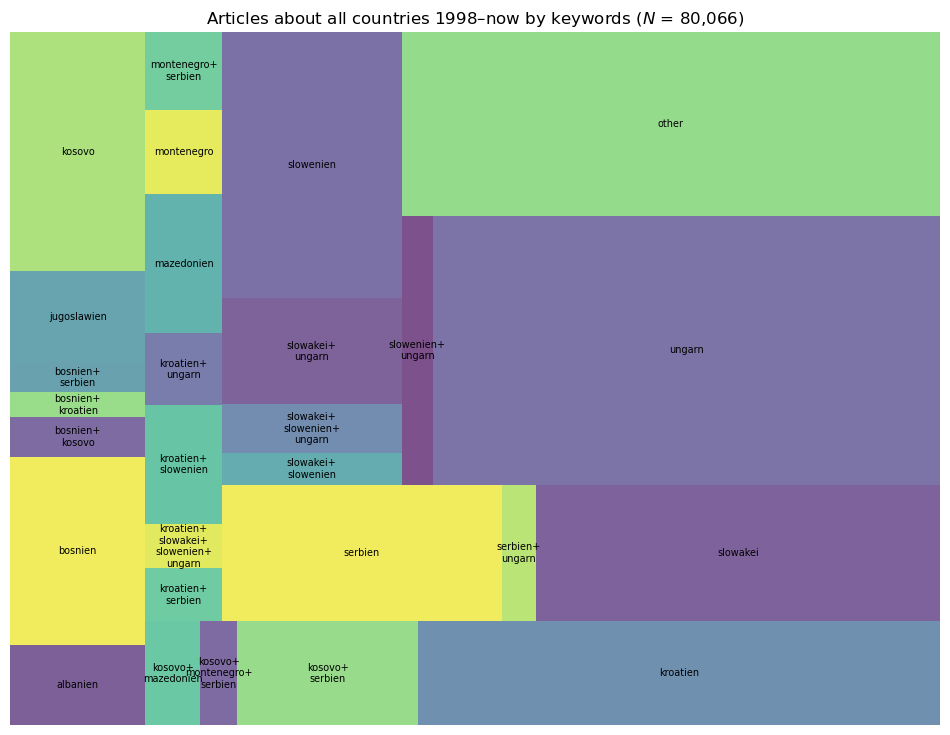

In [9]:
plot_count([], country_count, countries_min, 400)

#### Only articles that includes former Yugoslav countries (and controls removed)

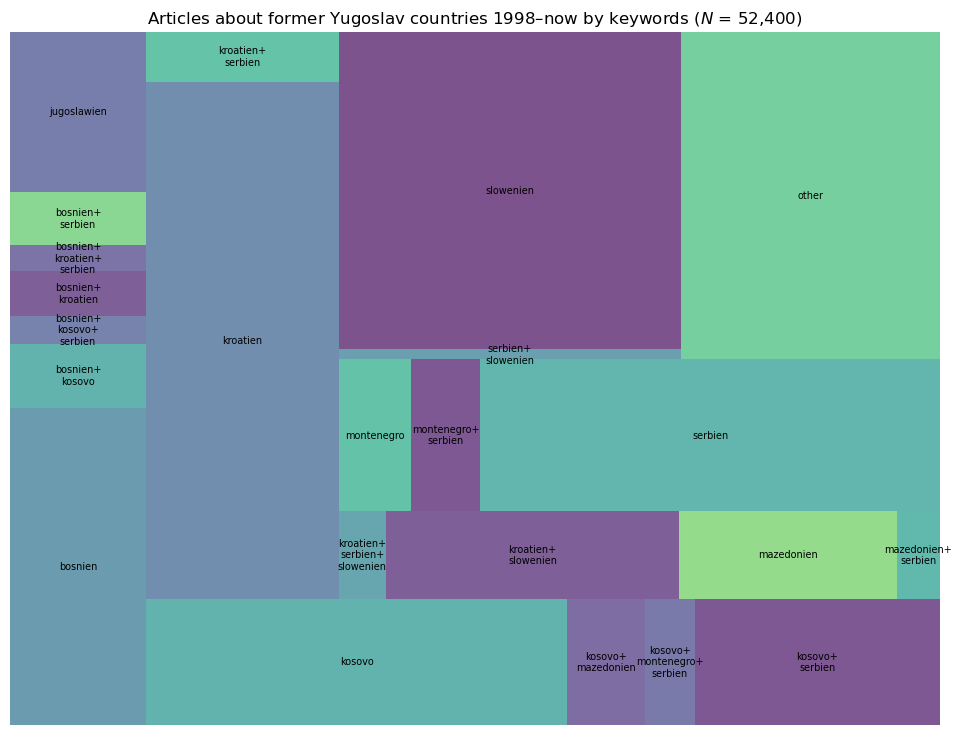

In [10]:
plot_count(
    [
        "yugoslavia",
        "croatia",
        "slovenia",
        "kosovo",
        "bosnia",
        "serbia",
        "montenegro",
        "northmacedonia",
    ],
    country_count_no_controls,
    countries_min,
    250,
    alt_title="Articles about former Yugoslav countries",
)

#### Only articles that include Serbia (controls removed)

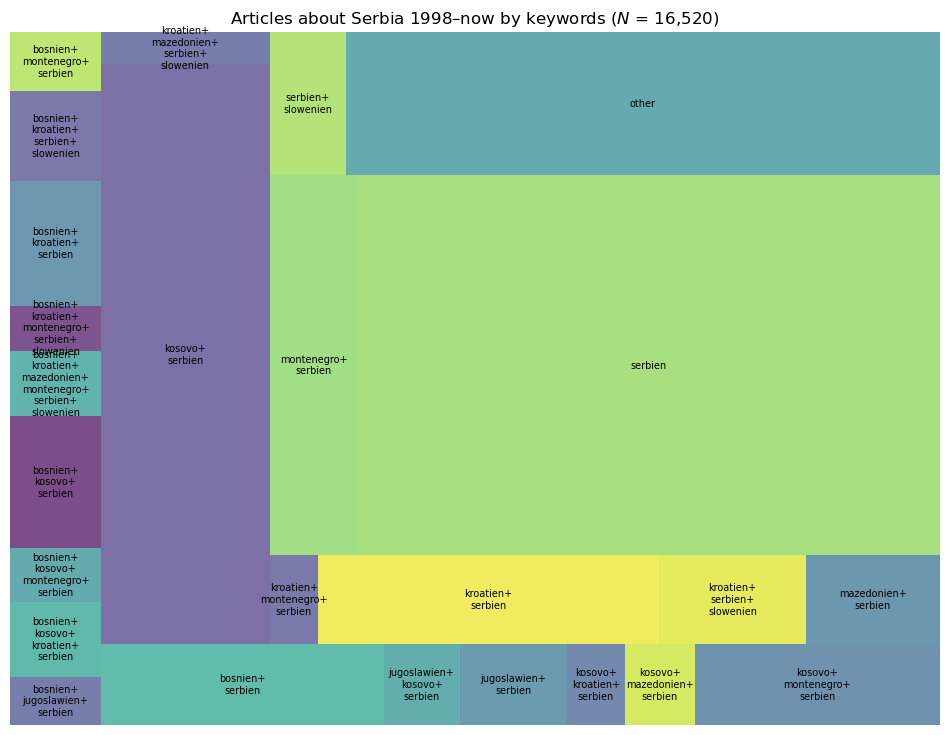

In [11]:
plot_count(["serbia"], country_count_no_controls, countries_min)

#### Only articles that include Croatia (controls removed)

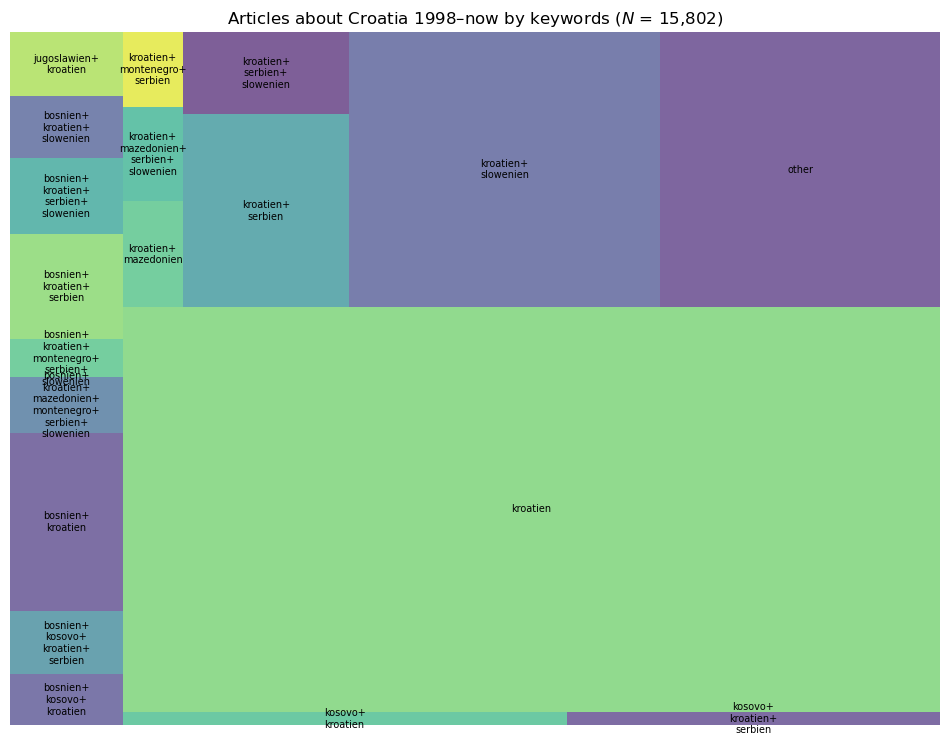

In [12]:
plot_count(["croatia"], country_count_no_controls, countries_min)

## Download

#### Create a sample (in case there are too many articles)

In [13]:
from numpy import random

random.seed(0)


keyword_filter = ["serbien", "kroatien"]  # only the "pure" articles
max_number_of_articles = 3_000

df_grp_sample = df_grp.copy()
df_grp_sample = df_grp_sample.loc[df_grp_sample.country.isin(keyword_filter)]

df_grp_sample = df_grp_sample.loc[
    df_grp_sample.id.isin(
        random.choice(df_grp_sample.id, size=max_number_of_articles, replace=False)
    )
].reset_index(drop=True)

#### Start downloading

In [ ]:
if os.path.exists(data_dir + "/articles") == False:
    os.makedirs(data_dir + "/articles")


for country in df_grp_sample.country.unique():
    
    
    print("Downloading articles for", country)

    df_country = df_grp.copy().loc[df_grp.country==country]

    for _, row in df_country.iterrows():
        filepath = data_dir + f"/articles/{row.id}.json"
        if os.path.exists(filepath) == False:
            try:
                a_title, a_subtitle, a_text, a_date = get_derstandard_article(row.url)
                with open(filepath, "w") as fp:
                    json.dump(dict(date=a_date, title=a_title, subtitle=a_subtitle, text=a_text), fp)
            except Exception as e:
                print("Problem with url", row.url, e)
        else:
            pass

## Preprocess text

In [148]:
# prerequisites:
#!python -m spacy download de_core_news_sm
# nltk.download("stopwords")
# nltk.download('punkt')

import contractions
import nltk
from num2words import num2words
from nltk.corpus import stopwords
import spacy
import inflect
import regex as re


nlp = spacy.load("de_core_news_sm")
p = inflect.engine()
stop_words = set(stopwords.words("german"))


def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    alphanumeric = re.sub(r"[^\w]", " ", input)
    return alphanumeric


def clean_tokenization_de(input):
    output = nltk.word_tokenize(input, "german")
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input, lang):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [num2words(item, lang=lang)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization_de(input):
    output = []
    for ip in input:
        doc = nlp(ip)
        result = " ".join([x.lemma_ for x in doc])
        output.append(result)
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def remove_custom(input):
    """
    Remove derstandard specific stuff
    such as 'BILD NICHT MEHR VERFÜGBAR'
    """
    output = input.replace("BILD NICHT MEHR VERFÜGBAR", "")
    output = output.replace("APA", "")

    return output


def preprocessing_de(text, remove_stopwords=True, custom=False):
    """
    Preprocessing pipeline for German language.
    """
    if custom:
        text = remove_custom(text)
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization_de(text)
    text = numbers_to_words(text, "de")
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization_de(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

### Check what we got

In [202]:
json_files = glob.glob(data_dir + "/articles/*.json")
print(len(json_files), "from", len(df_grp), "are downloaded.")

7922 from 80066 are downloaded.


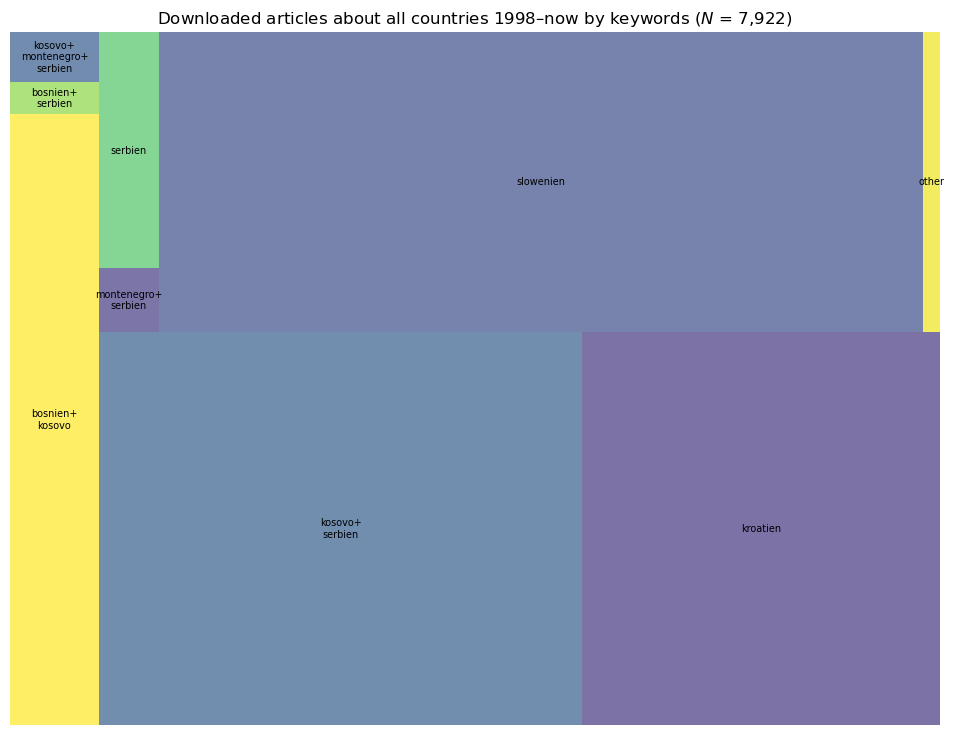

In [203]:
available_ids = list(
    pd.Series(json_files)
    .str.replace("\\", "/", regex=False)
    .str.split("/")
    .map(lambda x: x[-1])
    .str[:-5]
)

df_grp_available = (
    df_grp.loc[df_grp.id.isin(available_ids)].copy().reset_index(drop=True)
)

country_count_available = (
    df_grp_available.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)

plot_count(
    [],
    country_count_available,
    countries_min,
    20,
    alt_title="Downloaded articles about all countries",
)

<div class="alert alert-warning">This is still far from being a representative sample.</div>

## Sentiment analysis

* Pre-processing the text (report steps here)
* Using two different kinds of methods for computing sentiment scores (germansentimen and textblob_de)
* Validity of the 2 methods is checked by comparing them with each other through correlation
    * If correlation is too low then we have to assume that at least one of them doesn't measure the sentiment correctly
    * In this case: As we have no gold-standard to compare them to and we don't know which of the two is poor we can't interpret the results further
    
Correlation coefficient of 0.7 or higher is considered to indicate a high degree of consistency, a coefficient between 0.5 and 0.7 is considered to indicate a moderate consistency, and a coefficient below 0.5 is considered to indicate a poor consistency.

Scores were computed for 1,411 articles and the correlation 0.12. Therefore, sentiment analysis was not further pursued.

In [162]:
from germansentiment import SentimentModel
from textblob_de import TextBlobDE as TextBlob

gsm = SentimentModel()


def german_sentiment(txt, with_class=False):
    """

    returns sentiment score for
    German language.

    """

    [class_], [probs] = gsm.predict_sentiment([txt], output_probabilities=True)
    probs = dict(probs)
    if with_class == True:
        return class_, probs["positive"] - probs["negative"]
    return probs["positive"] - probs["negative"]

### Iterate over all available articles

Load

In [ ]:
# df_grp_available = pd.read_csv(data_dir + "/df_grp_available.csv")

Compute

In [ ]:
df_grp_available["german_sentiment"] = float("nan")
df_grp_available["textblob_de"] = float("nan")

    
for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]

    if pd.isna(row.german_sentiment):  # skip already computed scores
        txt = preprocessing_de(article, custom=True)
        df_grp_available.loc[i, "german_sentiment"] = german_sentiment(txt)
        df_grp_available.loc[i, "textblob_de"] = TextBlob(txt).polarity
        # report progress
        print(str(i)[-1], end="")

Save

In [ ]:
# df_grp_available.to_csv(data_dir + "/df_grp_available.csv", index=False)

Correlation

In [200]:
print(f"N = {len(df_grp_available.dropna())}")

N = 1411


In [195]:
df_grp_available[["german_sentiment", "textblob_de"]].corr()

,german_sentiment,textblob_de
german_sentiment,1.000000,0.120218
textblob_de,0.120218,1.000000


## Word frequency analysis

* As an additional analysis and in case the sentiment analysis turns out inconclusive I count words such as "nationalist", "ultra-nationalist", "regime", "despot", "herrscher", "totalitär", "rechtsradikal", "rechtsextrem", "extremistisch", "faschistisch", "kriegsverbrecher", "kriegsverbrechen" usw.
* These words are also negatively associated and could potentially be seen as a more targeted (political perspective) replacement for the sentiment analysis.
* This should be done only on the unprocessesed text (apply only lowercase)!
* I will build ratios between polemic vs neutral words and check if they differ between the countries and how they change over time.
* But is it so useful to build ratios here? A non-occurence of a control word will lead to a missing value in the ratio. Why not just compute the average occurences of certain words per article?

In [227]:
def compute_frequencies(text, category_list):
    """
    Function to calculate word frequencies.

    """

    count = 0

    for word in category_list:

        count += text.count(word)

    return count

Some bag of words

In [309]:
# maybe also macht, gewalt vs fortschritt, zukunft?

polemic_politician = [
    "diktator",
    "tyrann",
    "despot",
    "autokrat",
    "herrscher",
    "führer",
    "machthaber",
]

neutral_politician = [
    "premierminister",
    "premier",
    "regierungschef",
    "präsident",
    "kanzler",
    "parteivorsitzender",
]

polemic_gov = [
    "herrschaft",
    "regime",
    "diktatur",
    "tyrannis",
    "despotie",
    "autokratie",
    "staatsmacht",
    "machtelite",
    "herrschaftselite",
    "regierungsgewalt",
    "staatsgewalt",
    "obrigkeit",
]

neutral_gov = [
    "regierung",
    "staatsführung",
    "behörde",
    "staatliche institution",
    "staatlichen institution",
]

polemic_other = [
    "groß-serb",
    "großserb",
    "groß-kroat",
    "großkroat",
    "nationalist",
    "ultranationalist",
    "ultra-nationalist",
    "totalitär",
    "rechtsradikal",
    "rechtsextrem",
    "extremist",
    "faschist",
    "kriegsverbrech",
]

neutral_other = [
    "mensch",
    "person",
    "mann",
    "frau",
    "land",
    "männer",
    "frauen",
    "länder",
]

#### Compute frequencies for politician nouns

In [234]:
df_grp_available["polemic_politician"] = float("nan")
df_grp_available["neutral_politician"] = float("nan")


for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]
        article = article.lower()

    if pd.isna(row.polemic_politician) | pd.isna(
        row.neutral_politician
    ):  # skip already computed scores
        df_grp_available.loc[i, "polemic_politician"] = compute_frequencies(
            article, polemic_politician
        )
        df_grp_available.loc[i, "neutral_politician"] = compute_frequencies(
            article, neutral_politician
        )

Compute means

In [268]:
from scipy.stats import ttest_ind

In [305]:
keyword = "serbien"

print(
    f"Mean occurence of negatively associated words for the leading politician {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_politician']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for the leading politician 26% N = 174


In [306]:
keyword = "kroatien"

print(
    f"Mean occurence of negatively associated words for the leading politician {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_politician']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for the leading politician 14% N = 1728


In [307]:
keyword = "slowenien"

print(
    f"Mean occurence of negatively associated words for the leading politician {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_politician']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for the leading politician 13% N = 2820


T-Test Serbia Croatia

In [278]:
ttest_ind(
    df_grp_available.loc[df_grp_available.country == "serbien", ["polemic_politician"]],
    df_grp_available.loc[
        df_grp_available.country == "kroatien", ["polemic_politician"]
    ],
    permutations=50_000,
    alternative="greater",
)

Ttest_indResult(statistic=array([2.52785626]), pvalue=array([0.01894]))

#### Compute frequencies for government nouns

In [310]:
df_grp_available["polemic_gov"] = float("nan")
df_grp_available["neutral_gov"] = float("nan")


for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]
        article = article.lower()

    if pd.isna(row.polemic_gov) | pd.isna(
        row.neutral_gov
    ):  # skip already computed scores
        df_grp_available.loc[i, "polemic_gov"] = compute_frequencies(
            article, polemic_gov
        )
        df_grp_available.loc[i, "neutral_gov"] = compute_frequencies(
            article, neutral_gov
        )

Compute means

In [311]:
keyword = "serbien"

print(
    f"Mean occurence of negatively associated words for government {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_gov']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for government 15% N = 174


In [312]:
keyword = "kroatien"

print(
    f"Mean occurence of negatively associated words for government {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_gov']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for government 5% N = 1728


In [313]:
keyword = "slowenien"

print(
    f"Mean occurence of negatively associated words for government {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_gov']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words for government 3% N = 2820


T-Test Serbia Croatia

In [314]:
ttest_ind(
    df_grp_available.loc[df_grp_available.country == "serbien", ["polemic_gov"]],
    df_grp_available.loc[df_grp_available.country == "kroatien", ["polemic_gov"]],
    permutations=50_000,
    alternative="greater",
)

Ttest_indResult(statistic=array([4.16285423]), pvalue=array([0.00044]))

#### Compute frequencies for negative other

"nationalist", "rechtsextrem", "kriegsverbrecher" usw.

In [315]:
df_grp_available["polemic_other"] = float("nan")
df_grp_available["neutral_other"] = float("nan")


for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]
        article = article.lower()

    if pd.isna(row.polemic_other) | pd.isna(
        row.neutral_other
    ):  # skip already computed scores
        df_grp_available.loc[i, "polemic_other"] = compute_frequencies(
            article, polemic_other
        )
        df_grp_available.loc[i, "neutral_other"] = compute_frequencies(
            article, neutral_other
        )

Compute means

In [316]:
keyword = "serbien"

print(
    f"Mean occurence of negatively associated words nationalist, etc. {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_other']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words nationalist, etc. 78% N = 174


In [317]:
keyword = "kroatien"

print(
    f"Mean occurence of negatively associated words nationalist, etc.  {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_other']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated words nationalist, etc.  12% N = 1728


In [318]:
keyword = "slowenien"

print(
    f"Mean occurence of negatively associated nationalist, etc. words {df_grp_available.loc[df_grp_available.country == keyword, ['polemic_other']].mean().values[0]:.0%} N = {sum(df_grp_available.country == keyword)}",
)

Mean occurence of negatively associated nationalist, etc. words 3% N = 2820


T-Test Serbia Croatia

In [319]:
ttest_ind(
    df_grp_available.loc[df_grp_available.country == "serbien", ["polemic_other"]],
    df_grp_available.loc[df_grp_available.country == "kroatien", ["polemic_other"]],
    permutations=50_000,
    alternative="greater",
)

Ttest_indResult(statistic=array([11.41317365]), pvalue=array([0.]))

<div class="alert alert-warning">Report the cohen's to give an idea about the size of effect</div>

Group to create a time series

In [239]:
df_grp_available_grp = df_grp_available.groupby(
    ["country", "year"], as_index=False
).sum()

df_grp_available_grp["ratio_polemic_neutral_politician"] = (
    df_grp_available_grp["polemic_politician"]
    / df_grp_available_grp["neutral_politician"]
)

df_grp_available_grp

,country,year,polemic_politician,neutral_politician,ratio_polemic_neutral_politician
0,bosnien_jugoslawien_kosovo_montenegro_serbien,2008,0.0,0.0,NaN
1,bosnien_jugoslawien_kosovo_serbien,2008,0.0,5.0,0.000000
2,bosnien_jugoslawien_montenegro_serbien,2008,1.0,8.0,0.125000
3,bosnien_jugoslawien_serbien,2008,7.0,26.0,0.269231
4,bosnien_kosovo,1999,2.0,3.0,0.666667
...,...,...,...,...,...
111,slowenien,2013,27.0,185.0,0.145946
112,slowenien,2014,31.0,155.0,0.200000
113,slowenien,2015,14.0,92.0,0.152174
114,slowenien,2016,14.0,91.0,0.153846


## Sociodemographic data

* results (word frequency ratios) will be correlated with sociodemographic variables and events, political cycles etc.

In [ ]:
#
#
#

## Explorative: Extract authors



In [ ]:
#
#
#

## Explorative: Fuzzy topic modeling

* Extract underlying topics of articles
* Are there significant differences in the topics between articles about Croatia and articles Serbia?

In [ ]:
#
#
#

## Discussion

* In case correlations are low mention that sentiment score methods need to be evaluated for these kind of texts (German) as well as the pre-processing. In a follow-up step we could draw a sample of articles translate them to English and check if the english methods converge better (vader, textblob, ...).
* What do the results tell us? It can be both, showing the reality in these countries or a media bias. You can't tell it from the data.
* There could be some bias in the data because of famous people in Austria which leads to more mentions of a specific country in a specific way. We haven't controlled for that.